In [1]:
import os
from itertools import product
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm.autonotebook import tqdm

import bandit.environment as env
from bandit.bandit import Bandit, PerArmBandit
from bandit.policy import EGreedy, Softmax
from bandit.utils import snapshot

sns.set_theme()

/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_27585/1555042788.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import re


def to_snake_case(s):
    return re.sub(r"(?<!^)(?=[A-Z])", "_", s).lower()

## Setup Variables

In [3]:
N = 1_000
n_arms = len(env.actions)

In [4]:
file_name = "contextual_bandit.csv"
if not os.path.exists(file_name):
    df = pd.DataFrame(index=range(N))
    df.to_csv(file_name)
else:
    df = pd.read_csv(file_name)
df.head()

,logistic_regression__e_greedy_eps_0.1,logistic_regression__softmax_tau_0.2,decision_tree_regressor__e_greedy_eps_0.1,decision_tree_regressor__softmax_tau_0.2,m_l_p_regressor__e_greedy_eps_0.1,m_l_p_regressor__softmax_tau_0.2,logistic_regression_per_arm__e_greedy_eps_0.1
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.2,1.0,0.0


In [26]:
def run_simulation(bandit, policy, n=N, dynamic=False):
    total_reward = 0
    avg_rewards = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(N)):
        state = env.observe(rng)

        # 1. Predict the action.
        rewards = bandit.pull(state)

        action = policy(rewards)

        # 2. Act and get the reward.
        if dynamic and i > N // 2:
            get_cost = env.get_cost_new
        else:
            get_cost = env.get_cost
        reward = get_cost(state, env.actions[action])

        # 3. Update the model.
        bandit.update(state, action, reward)

        # 4. Save the reward.
        total_reward += max(0, reward)
        avg_rewards.append(total_reward / (i + 1))
    return avg_rewards, total_reward

## Setting up Contextual MAB

In [22]:
models = [
    LogisticRegression(random_state=42),
    DecisionTreeRegressor(random_state=42),
    MLPRegressor(random_state=42),
]
policies = [
    EGreedy(epsilon=0.1),
    Softmax(tau=0.2),
]

for model, policy in product(models, policies):
    model_name = f"{model.__class__.__name__}MAB_{policy.__class__.__name__}"
    if (val := policy.__dict__.get("tau", None)) is not None:
        model_name += f"_tau_{val}"
    elif (val := policy.__dict__.get("epsilon", None)) is not None:
        model_name += f"_eps_{val}"
    model_name = to_snake_case(model_name)
    if model_name in df:
        print("skipping", model_name)
        # if "Logistic" not in name and "Tree" not in name:
        # continue
        continue

    print("Running", model_name)
    with snapshot("contextual_bandit.json", model_name) as meta:
        avg_rewards, total_reward = run_simulation(Bandit(model, n_arms), policy)
        meta["total_reward"] = total_reward

    df[model_name] = avg_rewards
    df.to_csv(file_name, index=False)

skipping logistic_regression_m_a_b__e_greedy_eps_0.1
skipping logistic_regression_m_a_b__softmax_tau_0.2
skipping decision_tree_regressor_m_a_b__e_greedy_eps_0.1
skipping decision_tree_regressor_m_a_b__softmax_tau_0.2
skipping m_l_p_regressor_m_a_b__e_greedy_eps_0.1
skipping m_l_p_regressor_m_a_b__softmax_tau_0.2


## Setting up PerArm Contextual Bandit

In [25]:
models = [
    [LogisticRegression(random_state=42) for _ in range(n_arms)],
    [DecisionTreeRegressor(random_state=42) for _ in range(n_arms)],
    [MLPRegressor(random_state=42) for _ in range(n_arms)],
]
policies = [
    EGreedy(epsilon=0.1),
    Softmax(tau=0.2),
]

for models, policy in product(models, policies):
    model = models[0]
    model_name = f"{model.__class__.__name__}PerArm_{policy.__class__.__name__}"
    if (val := policy.__dict__.get("tau", None)) is not None:
        model_name += f"_tau_{val}"
    elif (val := policy.__dict__.get("epsilon", None)) is not None:
        model_name += f"_eps_{val}"
    model_name = to_snake_case(model_name)
    if model_name in df:
        print("skipping", model_name)
        # if "Logistic" not in name and "Tree" not in name:
        # continue
        continue

    print("Running", model_name)
    with snapshot("contextual_bandit.json", model_name) as meta:
        avg_rewards, total_reward = run_simulation(PerArmBandit(models), policy)
        meta["total_reward"] = total_reward

    df[model_name] = avg_rewards
    df.to_csv(file_name, index=False)

skipping logistic_regression_per_arm__e_greedy_eps_0.1
skipping logistic_regression_per_arm__softmax_tau_0.2
skipping decision_tree_regressor_per_arm__e_greedy_eps_0.1
skipping decision_tree_regressor_per_arm__softmax_tau_0.2
skipping m_l_p_regressor_per_arm__e_greedy_eps_0.1
skipping m_l_p_regressor_per_arm__softmax_tau_0.2


## Setting up Dynamic MAB Contextual Bandit

In [27]:
models = [
    LogisticRegression(random_state=42),
    DecisionTreeRegressor(random_state=42),
    MLPRegressor(random_state=42),
]
policies = [
    EGreedy(epsilon=0.1),
    Softmax(tau=0.2),
]

for model, policy in product(models, policies):
    model_name = f"{model.__class__.__name__}MAB_Dynamic_{policy.__class__.__name__}"
    if (val := policy.__dict__.get("tau", None)) is not None:
        model_name += f"_tau_{val}"
    elif (val := policy.__dict__.get("epsilon", None)) is not None:
        model_name += f"_eps_{val}"
    model_name = to_snake_case(model_name)
    if model_name in df:
        print("skipping", model_name)
        # if "Logistic" not in name and "Tree" not in name:
        # continue
        continue

    print("Running", model_name)
    with snapshot("contextual_bandit.json", model_name) as meta:
        avg_rewards, total_reward = run_simulation(
            Bandit(model, n_arms), policy, dynamic=True
        )
        meta["total_reward"] = total_reward

    df[model_name] = avg_rewards
    df.to_csv(file_name, index=False)

Running logistic_regression_m_a_b__dynamic__e_greedy_eps_0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Running logistic_regression_m_a_b__dynamic__softmax_tau_0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Running decision_tree_regressor_m_a_b__dynamic__e_greedy_eps_0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Running decision_tree_regressor_m_a_b__dynamic__softmax_tau_0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Running m_l_p_regressor_m_a_b__dynamic__e_greedy_eps_0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Running m_l_p_regressor_m_a_b__dynamic__softmax_tau_0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

## Setting up Dynamic PerArm Contextual Bandit

In [28]:
models = [
    [LogisticRegression(random_state=42) for _ in range(n_arms)],
    [DecisionTreeRegressor(random_state=42) for _ in range(n_arms)],
    [MLPRegressor(random_state=42) for _ in range(n_arms)],
]
policies = [
    EGreedy(epsilon=0.1),
    Softmax(tau=0.2),
]

for models, policy in product(models, policies):
    model = models[0]
    model_name = f"{model.__class__.__name__}PerArm_Dynamic_{policy.__class__.__name__}"
    if (val := policy.__dict__.get("tau", None)) is not None:
        model_name += f"_tau_{val}"
    elif (val := policy.__dict__.get("epsilon", None)) is not None:
        model_name += f"_eps_{val}"
    model_name = to_snake_case(model_name)
    if model_name in df:
        print("skipping", model_name)
        # if "Logistic" not in name and "Tree" not in name:
        # continue
        continue

    print("Running", model_name)
    with snapshot("contextual_bandit.json", model_name) as meta:
        avg_rewards, total_reward = run_simulation(
            PerArmBandit(models), policy, dynamic=True
        )
        meta["total_reward"] = total_reward

    df[model_name] = avg_rewards
    df.to_csv(file_name, index=False)

Running logistic_regression_per_arm__dynamic__e_greedy_eps_0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Running logistic_regression_per_arm__dynamic__softmax_tau_0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Running decision_tree_regressor_per_arm__dynamic__e_greedy_eps_0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Running decision_tree_regressor_per_arm__dynamic__softmax_tau_0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Running m_l_p_regressor_per_arm__dynamic__e_greedy_eps_0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Running m_l_p_regressor_per_arm__dynamic__softmax_tau_0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
# Override
# You will get unnamed columns if saved with index=True
# df[[col for col in df.columns if 'Unnamed' not in col]]
# df.to_csv(file_name, index=False)

In [29]:
def plot(*patterns):
    cols = df.columns
    for pat in patterns:
        cols = list(filter(lambda col: pat in col, cols))

    style = []
    for col in cols:
        if "e_greedy" in col:
            style.append("-")
        elif "softmax" in col:
            style.append("--")
        else:
            style.append("-")
    df[cols].plot(
        figsize=(12, 8),
        style=style,
        xlabel="Trials",
        ylabel="Avg. Rewards",
        title="Contextual Bandit",
    )

## Plots

### All

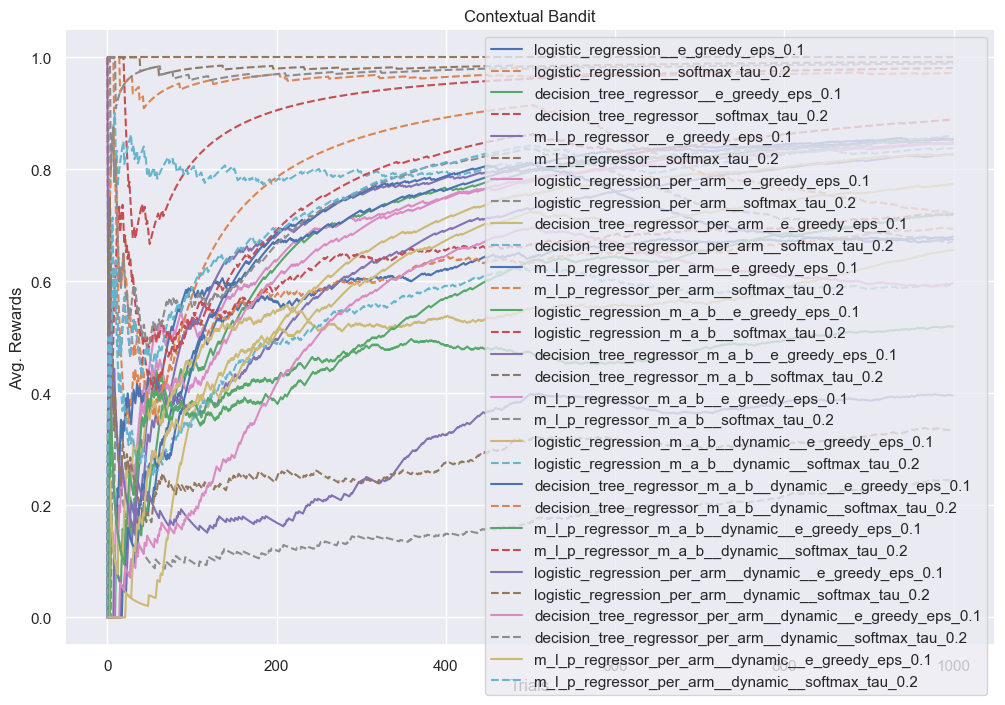

In [30]:
plot()

### Softmax PerArm

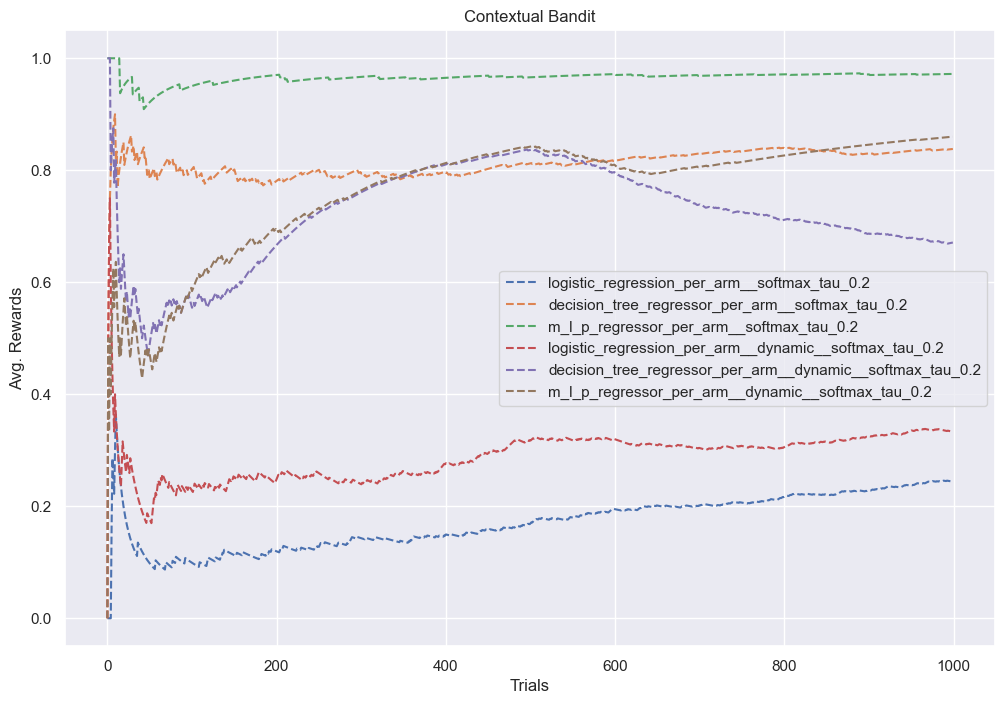

In [31]:
plot("per_arm", "softmax")

### Softmax MAB

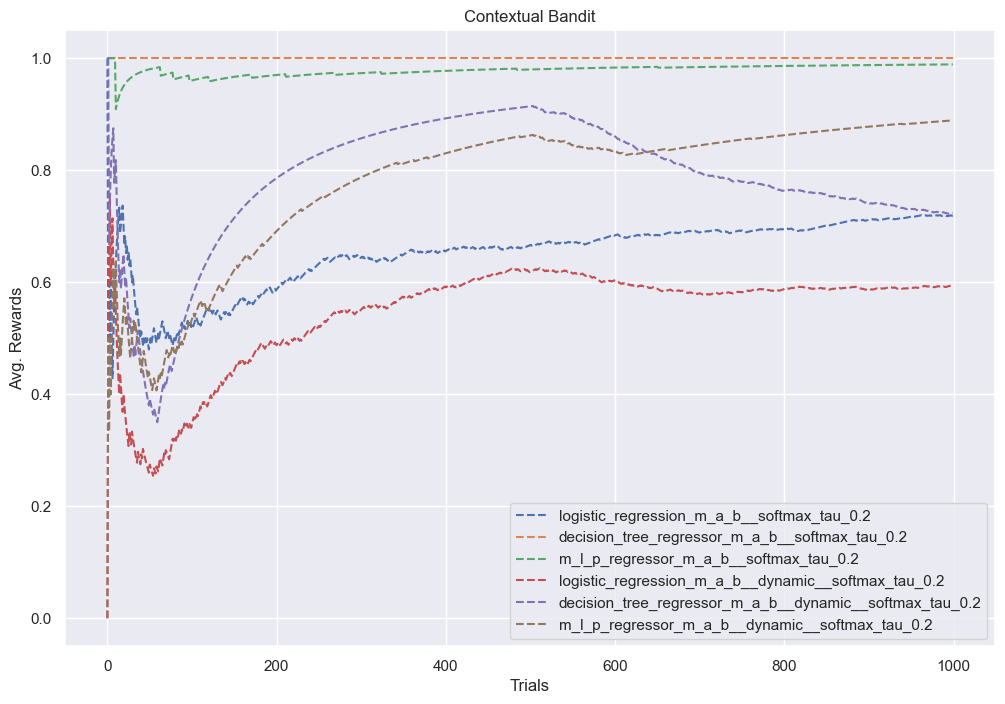

In [32]:
plot("m_a_b", "softmax")

## Softmax Dynamic MAB

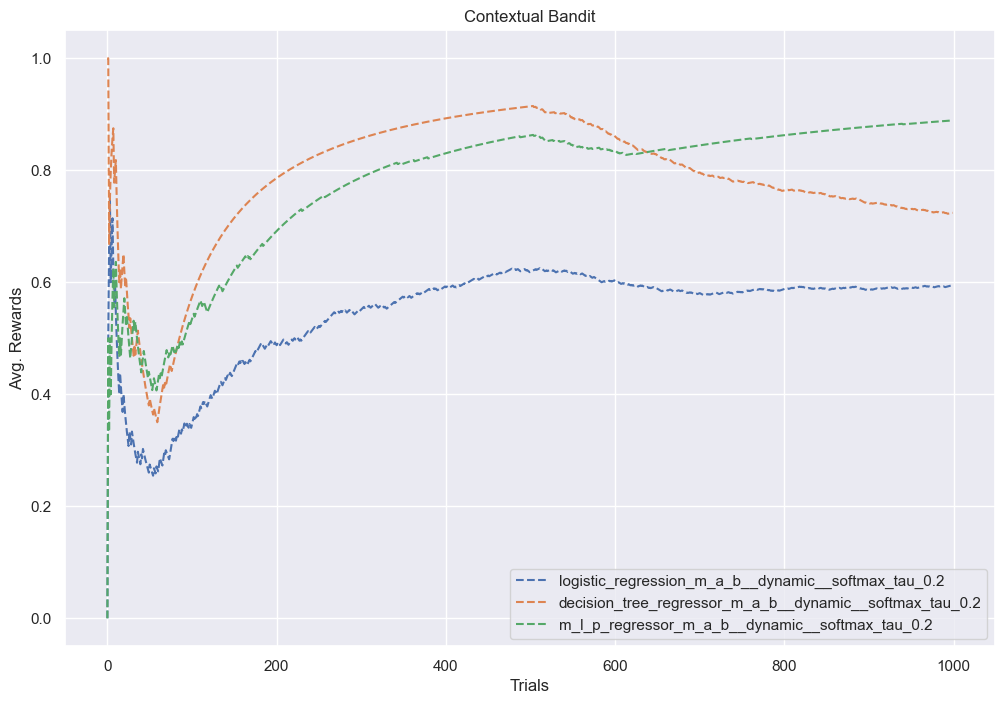

In [34]:
plot("m_a_b", "softmax", "dynamic")

## Softmax Dynamic Per Arm

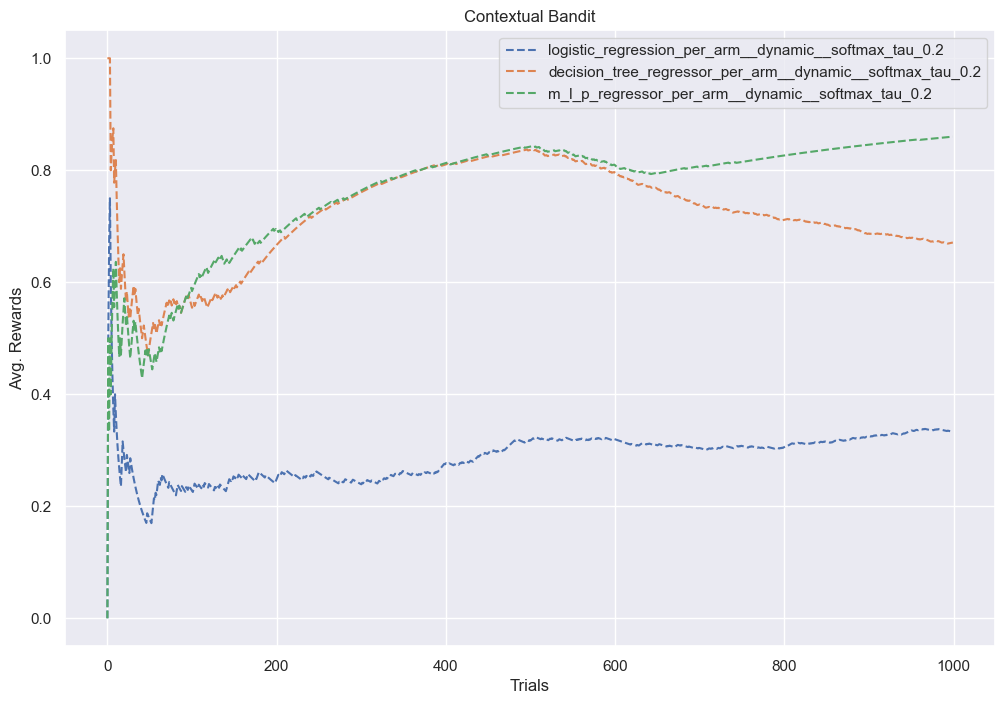

In [33]:
plot("per_arm", "softmax", "dynamic")